In [1]:
# https://wikidocs.net/44249 참고

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

In [3]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
wp_review = pd.read_csv('../../data/물놀이/review_crawling_ansi_labeled_finished.csv', encoding='CP949')
df = wp_review.copy()
df.head()

,물놀이장,리뷰,라벨
0,희망어린이공원 계류,원래는 소귀어린이공원(잠자리놀이터)을 자주 이용했었는데... 벤치도 그렇고 미끄럼틀...,0
1,희망어린이공원 계류,풍경을바라보며쉴수있는좋은공간이에요,1
2,희망어린이공원 계류,공동 화장실이 있었음 좋겠어요~,1
3,희망어린이공원 계류,어린이들이 맘껏 뛰어놀수있는. 그런공간이네요,1
4,희망어린이공원 계류,어린이 놀이터가 있는 공원 - 화장실은 없다,0


In [5]:
df['라벨'].value_counts()

1    1990
0     365
Name: 라벨, dtype: int64

In [6]:
print("긍정 리뷰의 비율 : ", round((df['라벨'].value_counts()[1] / len(df))*100, 1), "%")

긍정 리뷰의 비율 :  84.5 %


## 1. 전처리

### 긍정, 부정 데이터 개수 맞추기

In [7]:
# 긍정데이터만 들어있는 df1
df1 = df[df['라벨'] == 1]
df1.reset_index(drop=True, inplace=True)

# df1에서 부정 데이터 개수만큼 랜덤 추출
import random
random.seed(1000)
df1_index = random.sample(range(0, len(df1)), df['라벨'].value_counts()[0])  # 긍정 데이터의 인덱스에서 긍정 데이터에서 부정 데이터의 개수만큼 숫자 랜덤 추출
df1 = df1.iloc[df1_index, :]

In [8]:
df = pd.concat([df1, df[df['라벨'] == 0]])
df

,물놀이장,리뷰,라벨
1592,둘리쌍문근린공원,코로나로 인해 정식오픈까지 2년소요됨.\n초미니캐러비안베이!!\n관리자도 최소 ...,1
878,성내천 물놀이장,아기들에게 좋은 물놀이 장소입니다,1
1371,뚝섬 수영장,좋아요,1
1557,등나무문화공원,걍뭐,1
203,천왕근린공원 물놀이장,야생화와 연꽃 연못이 어우러진 예쁜 공원입니다,1
...,...,...,...
2297,공 릉 동,노인들이 이용도 안하는 골프연습장으로 다 막아놔서 시설낭비,0
2299,공 릉 동,접근성이 떨어져요,0
2305,공 릉 동,물 수질이 나쁨,0
2325,공 릉 동,게이들이 많다,0


In [9]:
# 한글과 공백을 제외하고 모두 제거
df['리뷰'] = df['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex = True)
df['리뷰'][:5]

1592    코로나로  인해 정식오픈까지  년소요됨초미니캐러비안베이관리자도 최소 명이상 배치한듯...
878                                    아기들에게 좋은 물놀이 장소입니다
1371                                                  좋아요
1557                                                   걍뭐
203                             야생화와 연꽃 연못이 어우러진 예쁜 공원입니다
Name: 리뷰, dtype: object

In [10]:
# feature, target 분리
X = df['리뷰']
y = df['라벨']

In [11]:
# Train set, Test set 분리 
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

### 토큰화

In [12]:
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [13]:
# 학습 데이터 토큰화
X_train = []
for sentence in tqdm(x_train):
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]  # 불용어 제거
    X_train.append(stopwords_removed_sentence)

100%|████████████████████████████████████████████████████████████████████████████████| 584/584 [00:09<00:00, 64.85it/s]


In [14]:
print(X_train[:3])

[['편하다', '다니다', '공원', '이다', '요즈음', '들다', '공사', '또', '하고', '왜', '그런', '가요'], ['밤', '운동', '나오다', '좋다', '개', '많다', '멍멍'], ['깨끗하다', '좋다', '화장실', '탈의실', '샤워', '장도', '바로', '옆', '있다', '좋다']]


In [15]:
# 테스트 데이터토큰화
X_test = []
for sentence in tqdm(x_test):
    tokenized_sentence = okt.morphs(sentence, stem=True)  # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords]  # 불용어 제거
    X_test.append(stopwords_removed_sentence)

100%|███████████████████████████████████████████████████████████████████████████████| 146/146 [00:00<00:00, 367.48it/s]


In [16]:
print(X_test[:3])

[['날', '마다', '오다', '화장실', '을', '잠그다', '놓다', '온', '산이', '화장실', '되다', '화장실', '을', '열다'], ['공원', '이기다', '하나', '동물', '함께', '공간', '을', '사용', '동물', '로', '인하다', '환경', '소변', '대변', '여기', '저기', '서', '보다', 'ㅜㅜ'], ['시설', '그다지', '깨끗하다', '않다', '하지만', '여름', '한강', '가다', '김', '가기', '좋다']]


### 정수 인코딩

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [18]:
print(tokenizer.word_index)

{'좋다': 1, '있다': 2, '공원': 3, '아이': 4, '곳': 5, '많다': 6, '을': 7, '이다': 8, '너무': 9, '않다': 10, '없다': 11, '놀다': 12, '사람': 13, '로': 14, '에서': 15, '화장실': 16, '물놀이': 17, '운동': 18, '수영장': 19, '물': 20, '산책': 21, '다': 22, '되다': 23, '것': 24, '보다': 25, '시설': 26, '수': 27, '같다': 28, '가다': 29, '깨끗하다': 30, '놀이터': 31, '안': 32, '어린이': 33, '하고': 34, '만': 35, '고': 36, '쉬다': 37, '자다': 38, '원': 39, '여름': 40, '되어다': 41, '물이': 42, '크다': 43, '요': 44, '에는': 45, '장': 46, '분': 47, '분수': 48, '공간': 49, '주차': 50, '더': 51, '공': 52, '이용': 53, '장소': 54, '오다': 55, '적': 56, '가깝다': 57, '무료': 58, '들다': 59, '시간': 60, '비': 61, '많이': 62, '공사': 63, '나오다': 64, '바닥': 65, '관리': 66, '이라': 67, '애': 68, '주변': 69, '작다': 70, '저렴하다': 71, '조금': 72, '근처': 73, '동네': 74, '수영모': 75, '개': 76, '옆': 77, '그': 78, '생각': 79, '나': 80, '엔': 81, '코로나': 82, '아쉽다': 83, '최고': 84, '나무': 85, '괜찮다': 86, '아니다': 87, '가족': 88, '성인': 89, '넓다': 90, '서': 91, '안전': 92, '중': 93, '밤': 94, '냄새': 95, '정도': 96, '소나무': 97, '기': 98, '그렇다': 99, '시': 100, '대': 101, '먹다': 1

In [19]:
threshold = 3
total_cnt = len(tokenizer.word_index)  # 단어의 수
rare_cnt = 0  # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


##### 결과 #####
# 단어 집합(vocabulary)의 크기 : 2219
# 등장 빈도가 2번 이하인 희귀 단어의 수: 1636
# 단어 집합에서 희귀 단어의 비율: 73.72690401081569
# 전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 24.77337638147274

단어 집합(vocabulary)의 크기 : 2099
등장 빈도가 2번 이하인 희귀 단어의 수: 1519
단어 집합에서 희귀 단어의 비율: 72.36779418770844
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 23.73035459150539


In [20]:
# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한

In [21]:
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 581


In [22]:
# 케라스 토크나이저의 인자로 넘겨주고 텍스트 시퀀스를 정수 시퀀스로 변환
tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [23]:
print(X_train[:3])

[[131, 344, 3, 8, 59, 63, 195, 34, 262, 434], [94, 18, 64, 1, 76, 6], [30, 1, 16, 263, 264, 196, 77, 2, 1]]


In [24]:
# train_data에서 y_train과 y_test를 별도로 저장
y_train = np.array(y_train)
y_test = np.array(y_test)

In [25]:
# 빈 샘플(empty samples) 제거

In [26]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [27]:
# 빈 샘플들을 제거
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

574
574


C:\ProgramData\anaconda3\lib\site-packages\numpy\lib\function_base.py:5071: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


## 2. 학습

### 패딩

리뷰의 최대 길이 : 68
리뷰의 평균 길이 : 10.229965156794425


(array([93., 45., 98., 38., 28., 71., 20., 20., 34., 12., 13., 16., 11.,
         7.,  4.,  4.,  5.,  3.,  6.,  6.,  6.,  2.,  1.,  6.,  1.,  1.,
         3.,  2.,  0.,  0.,  2.,  2.,  0.,  1.,  1.,  2.,  1.,  1.,  1.,
         1.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  2.]),
 array([ 1.  ,  2.34,  3.68,  5.02,  6.36,  7.7 ,  9.04, 10.38, 11.72,
        13.06, 14.4 , 15.74, 17.08, 18.42, 19.76, 21.1 , 22.44, 23.78,
        25.12, 26.46, 27.8 , 29.14, 30.48, 31.82, 33.16, 34.5 , 35.84,
        37.18, 38.52, 39.86, 41.2 , 42.54, 43.88, 45.22, 46.56, 47.9 ,
        49.24, 50.58, 51.92, 53.26, 54.6 , 55.94, 57.28, 58.62, 59.96,
        61.3 , 62.64, 63.98, 65.32, 66.66, 68.  ]),
 <BarContainer object of 50 artists>)

Text(0.5, 0, 'length of samples')

Text(0, 0.5, 'number of samples')

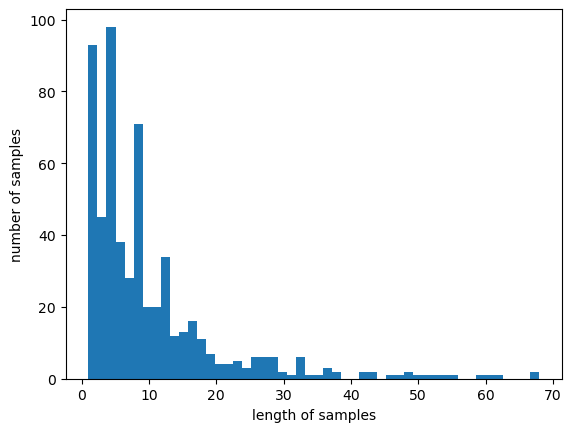

In [28]:
print('리뷰의 최대 길이 :', max(len(review) for review in X_train))
print('리뷰의 평균 길이 :', sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [29]:
def below_threshold_len(max_len, nested_list):
    count = 0
    for sentence in nested_list:
        if(len(sentence) <= max_len):
            count = count + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [30]:
max_len = 30
below_threshold_len(max_len, X_train)
# max_len = 30 일 경우, 비율은 93.7%
# max_len = 25 일 경우, 비율은 90.6%

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.42508710801394


In [31]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

### LSTM으로 리뷰 감성 분류

In [32]:
# 모델 및 토크나이저 경로 설정 
filepath = '../../../deeplearning/'

In [33]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# learning
embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(filepath + 'best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
8/8 [==============================] - ETA: 0s - loss: 0.6880 - acc: 0.5468
Epoch 1: val_acc improved from -inf to 0.59130, saving model to ../../../deeplearning\best_model.h5


C:\Users\HPE\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 4s 198ms/step - loss: 0.6880 - acc: 0.5468 - val_loss: 0.6728 - val_acc: 0.5913
Epoch 2/15
7/8 [=========================>....] - ETA: 0s - loss: 0.6643 - acc: 0.6384
Epoch 2: val_acc improved from 0.59130 to 0.63478, saving model to ../../../deeplearning\best_model.h5
8/8 [==============================] - 0s 50ms/step - loss: 0.6671 - acc: 0.6296 - val_loss: 0.6710 - val_acc: 0.6348
Epoch 3/15
7/8 [=========================>....] - ETA: 0s - loss: 0.6502 - acc: 0.7076
Epoch 3: val_acc did not improve from 0.63478
8/8 [==============================] - 0s 38ms/step - loss: 0.6482 - acc: 0.7124 - val_loss: 0.6427 - val_acc: 0.6000
Epoch 4/15
7/8 [=========================>....] - ETA: 0s - loss: 0.6050 - acc: 0.7009
Epoch 4: val_acc did not improve from 0.63478
8/8 [==============================] - 0s 38ms/step - loss: 0.6035 - acc: 0.7059 - val_loss: 0.6722 - val_acc: 0.5652
Epoch 5/15
7/8 [=========================>....] - ETA: 0s - loss: 0.568

In [34]:
# 모델 테스트 
loaded_model = load_model(filepath + 'best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

5/5 [==============================] - 1s 72ms/step - loss: 0.5633 - acc: 0.7603

 테스트 정확도: 0.7603


In [35]:
# 토크나이저 파일로 저장
with open(filepath + 'tokenizer.pickle', 'wb') as handle:
     pickle.dump(tokenizer, handle)

In [36]:
# 토크나이저 파일 로드 
with open(filepath + 'tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

## 3. 실제 데이터에 적용

### 리뷰 예측 예시

In [37]:
def sentiment_predict(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):
        print("{:.2f}% 확률로 긍정 리뷰입니다.\n".format(score * 100))
    else:
        print("{:.2f}% 확률로 부정 리뷰입니다.\n".format((1 - score) * 100))

In [38]:
ex1 = wp_review['리뷰'][0]
ex1
sentiment_predict(ex1)

'원래는 소귀어린이공원(잠자리놀이터)을 자주 이용했었는데... 벤치도 그렇고 미끄럼틀도 망가진 곳이 많고 초등학생들이 너무 많아서 어린 유아들이 놀기 좀 위험해서 희망어린이공원(성실교회뒤놀이터)으로 가기 시작했음.\n화장실이 없어 아쉽긴 하지만 적당한 그늘도 좀 있도, 공간도 좀 넓고...좀 과격하게 노는 초등학생들이 거의 없어서 유아들이 놀기 적당한!\n진짜 공중화장실만 있음 딱! 좋은데 아쉬운....'

1/1 [==============================] - 0s 450ms/step
100.00% 확률로 부정 리뷰입니다.



In [39]:
ex2 = wp_review['리뷰'][52]
ex2
sentiment_predict(ex2)

'친정에 가면 자전거 빌려타는라 꼭 갑니다.운동기구도 있고 산책하기도 좋아요.'

1/1 [==============================] - 0s 22ms/step
99.49% 확률로 긍정 리뷰입니다.



In [40]:
ex3 = wp_review['리뷰'][152]
ex3
sentiment_predict(ex3)

'밤12시쯤도착현대월드타워앞도착문제는그앞에서많은분들이담배피우고있고.학원이많아서인지아버지들이차타고많이들기다리고계시네여..공공장소에서애정행각도보이고그냥썩좋지만은안아요..학원다니시는분들아범니들생각해서좋은성적거두세요..화이팅입니다'

1/1 [==============================] - 0s 22ms/step
100.00% 확률로 부정 리뷰입니다.



### 리뷰 예측 결과

In [41]:
def sentiment_predict_return(new_sentence):
    new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    
    if(score > 0.5):
        return 1
    else:
        return 0

In [42]:
# 리뷰 예측 결과 저장
review_list = wp_review['리뷰']
pred_list = []  # 예측 결과. 1이 긍정, 0이 부정

for review in review_list:
    pred = sentiment_predict_return(review)
    pred_list.append(pred)

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 22ms/step


In [43]:
pred_list

[0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,


In [44]:
wp_review['예측'] = pred_list
wp_review

,물놀이장,리뷰,라벨,예측
0,희망어린이공원 계류,원래는 소귀어린이공원(잠자리놀이터)을 자주 이용했었는데... 벤치도 그렇고 미끄럼틀...,0,0
1,희망어린이공원 계류,풍경을바라보며쉴수있는좋은공간이에요,1,1
2,희망어린이공원 계류,공동 화장실이 있었음 좋겠어요~,1,1
3,희망어린이공원 계류,어린이들이 맘껏 뛰어놀수있는. 그런공간이네요,1,1
4,희망어린이공원 계류,어린이 놀이터가 있는 공원 - 화장실은 없다,0,0
...,...,...,...,...
2350,공 릉 동,좋아요,1,1
2351,공 릉 동,공원은 그렇게 좋지 않습니다. 3면이 도로로 둘러싸여 있습니다. 그들은 최근에 '미...,0,1
2352,공 릉 동,산책과 휴식을 취하기에 너무 좋은 곳입니다.,1,1
2353,공 릉 동,많이 붐비지 않고 깨끗합니다,1,1


### 각 물놀이장에 대해 점수화

In [45]:
wp = pd.read_csv('../../data/물놀이/WP.csv', encoding='utf-8')
wp.head()

,waterplayname,waterplayimgurl,waterplayaddrold,waterplayaddrnew,waterplaytelno,waterplayurl,waterplayname01,waterplayvalue01,waterplayname02,waterplayvalue02,...,waterplayshortvalue01,waterplayscoremean,waterplaywordcloudurl,waterplayscoretoiletmean,waterplayscoreconvmean,waterplayscoredrugmean,waterplayscoremedimean,waterplayscoresafe112mean,waterplayscoresafe119mean,waterplayscoreparkingmean
0,서울식물원 물놀이터,https://map.seoul.go.kr//smgis2/file/ucimgs/co...,강서구 마곡동 812,서울특별시 강서구 마곡동로 161,02-2104-9738,seoul.go.kr,운영기간,2022.7.01.(토)~8.31.(목),운영시간,(매일)11:00~16:40/하루 5회(매회 40분씩)\n휴무일 : 매주 월요일\n...,...,2022.7.01.(토)~8.31.(목),68,NaN,2.280043,3.244495,1.537011,3.126682,2.671342,3.075831,1.779510
1,사랑어린이공원,https://map.seoul.go.kr//smgis2/file/ucimgs/co...,노원구 상계동 765,서울특별시 노원구 동일로213길 21,02-2116-3975,0,운영기간,2023. 5.8. ~ 8.31.,운영시간,"12:00 ~ 16:40 (40분가동, 20분 휴동)",...,2023. 5.8. ~ 8.31.,71,https://i.ibb.co/88GF0Y8/image.png,2.244367,3.666769,2.235855,3.541158,3.147812,3.453221,1.961768
2,난지 물놀이장분수,https://map.seoul.go.kr//smgis2/file/ucimgs/co...,마포구 상암동 482-182,0,0,https://hangang.seoul.go.kr/www/contents/858.d...,이용기간,7~8월,운영시간,매회 20분. 월요일은 가동 정지\n12:00 ~ 18:00 (매 시간 정각 가동),...,7~8월,58,NaN,2.244367,3.666769,2.235855,3.541158,3.147812,3.453221,1.961768
3,복사꽃어린이공원,https://map.seoul.go.kr//smgis2/file/ucimgs/co...,마포구 도화동 533,서울특별시 마포구 마포대로4길 11-2,02-3153-9576,0,운영기간,2023. 5. 1.(월) ~ 9. 27.(수),운영시간,10:00~18:00 \n -1일 7~8회(회당 40분 가동),...,2023. 5. 1.(월) ~ 9. 27.(수),58,https://i.ibb.co/qxjvmHs/image.png,2.244367,3.666769,2.235855,3.541158,3.147812,3.453221,1.961768
4,거리공원 바닥분수,https://map.seoul.go.kr//smgis2/file/ucimgs/co...,구로구 구로동 50,서울특별시 구로구 공원로 73-1,02-860-3162,www.guro.go.kr,운영기간,2023.6.5.(월)~8.31.(목),운영시간,"(매일)12:00, 13:00, 16:00, 17:00 / 하루 4회(매회 30분씩)",...,2023.6.5.(월)~8.31.(목),66,NaN,2.244367,3.666769,2.235855,3.541158,3.147812,3.453221,1.961768


In [46]:
# 점수의 분모 
review_total_counts = wp_review['물놀이장'].value_counts().sort_index()
review_total_counts[:10]

공 릉 동          141
광나루 수영장         24
난지 물놀이장         72
느 티 울           27
능산공원            61
다산어린이공원         61
덕의근린공원 물놀이장     55
둘리쌍문근린공원        23
들 국 화           23
등나무문화공원        194
Name: 물놀이장, dtype: int64

In [47]:
# 점수의 분자 
review_positive_counts = wp_review['예측'].groupby(wp_review['물놀이장']).sum().sort_index()
review_positive_counts[:10]

물놀이장
공 릉 동          119
광나루 수영장         15
난지 물놀이장         46
느 티 울           22
능산공원            57
다산어린이공원         44
덕의근린공원 물놀이장     49
둘리쌍문근린공원        18
들 국 화           18
등나무문화공원        165
Name: 예측, dtype: int64

In [48]:
# 리뷰가 달린 물놀이장 이름 리스트
wp_review_list = wp_review['물놀이장'].unique()

In [49]:
# 리뷰가 달린 물놀이장의 인덱스 추출
wp_review_index = wp[wp['waterplayname'].isin(wp_review_list)].sort_values('waterplayname').index

# 리뷰 긍정 부정 점수 삽입
wp.iloc[wp_review_index, -1] = (review_positive_counts / review_total_counts) * 100

In [50]:
# 삽입 확인
wp[wp['waterplayname'] == '공 릉 동']

,waterplayname,waterplayimgurl,waterplayaddrold,waterplayaddrnew,waterplaytelno,waterplayurl,waterplayname01,waterplayvalue01,waterplayname02,waterplayvalue02,...,waterplayshortvalue01,waterplayscoremean,waterplaywordcloudurl,waterplayscoretoiletmean,waterplayscoreconvmean,waterplayscoredrugmean,waterplayscoremedimean,waterplayscoresafe112mean,waterplayscoresafe119mean,waterplayscoreparkingmean
19,공 릉 동,0,노원구 공릉동 63,서울특별시 노원구 화랑로 540,02-2116-3968,https://blog.naver.com/goodnowon/223139084873,운영기간,2023. 7. 1. ~ 8. 27.(매주 월요일 휴장),운영시간,"11:00 ~ 16:45(45분가동, 15분 휴동)",...,2023. 7. 1. ~ 8. 27.(매주 월요일 휴장),71,https://i.ibb.co/VVYhqsN/image.png,2.280043,3.244495,1.537011,3.126682,2.671342,3.075831,84.397163


In [51]:
# wp_review.to_csv('../../data/물놀이/review_crawling_pred.csv', index=False, encoding='utf-8')
# wp_review.to_csv('../../data/물놀이/review_crawling_pred_cp949.csv', index=False, encoding='CP949')
# wp.to_csv('../../data/물놀이/wp.csv', index=False, encoding='utf-8')
# wp.to_csv('../../data/물놀이/wp_euc.csv', index=False, encoding='euc-kr')